In [1]:
import pandas as pd
import os
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import plotly.express as px
import folium
from folium.plugins import MarkerCluster
from ipywidgets import interact_manual, Checkbox



In [2]:
folder_path = os.getcwd()

dataframe_names = [filename for filename in os.listdir(folder_path) if filename.endswith('.csv')]
dataframes = [[dataframe_names[i], dataframe_names[i+1]] for i in range(len(dataframe_names)-1) if dataframe_names[i].split('_')[0] == dataframe_names[i+1].split('_')[0]]

In [3]:
dataframes

[['amsterdam_weekdays.csv', 'amsterdam_weekends.csv'],
 ['athens_weekdays.csv', 'athens_weekends.csv'],
 ['barcelona_weekdays.csv', 'barcelona_weekends.csv'],
 ['berlin_weekdays.csv', 'berlin_weekends.csv'],
 ['budapest_weekdays.csv', 'budapest_weekends.csv'],
 ['lisbon_weekdays.csv', 'lisbon_weekends.csv'],
 ['london_weekdays.csv', 'london_weekends.csv'],
 ['paris_weekdays.csv', 'paris_weekends.csv'],
 ['rome_weekdays.csv', 'rome_weekends.csv'],
 ['vienna_weekdays.csv', 'vienna_weekends.csv']]

## Concatenate the dataframes 

In [4]:

common_locations_combined = pd.DataFrame()
for i in dataframes:
    df_name = i[0].split('_')[0]
    df_d = pd.read_csv(i[0])
    df_e = pd.read_csv(i[1])
    
    #drop unuseful columns
    df_d = df_d.drop(['Unnamed: 0', 'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm', 'room_shared', 'room_private'], axis=1)
    df_e = df_e.drop(['Unnamed: 0', 'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm', 'room_shared', 'room_private'], axis=1)
    


    df_d.insert (1, "City", df_name.title())
    df_e.insert (1, "City", df_name.title())
    
    df_d[["dist", 'metro_dist', 'realSum']] = df_d[["dist", 'metro_dist', 'realSum']].round(2)
    df_e[["dist", 'metro_dist', 'realSum']] = df_e[["dist", 'metro_dist', 'realSum']].round(2)
    
    df_d[["lng", 'lat']] = df_d[["lng", 'lat']].round(6)
    df_e[["lng", 'lat']] = df_e[["lng", 'lat']].round(6)
    
    #create a dataframe that combines the common points per city
    df = pd.merge(df_d, df_e, on=df_d.columns.difference(['realSum']).tolist(), suffixes=("_weekday", "_weekend"))
    common_locations_combined = pd.concat([common_locations_combined, df], ignore_index=True)

In [5]:
#some preprocessing
common_locations_combined['guest_satisfaction_overall'] = common_locations_combined['guest_satisfaction_overall'].astype(float) / 10
common_locations_combined["Weekday price"] = common_locations_combined["realSum_weekday"]
common_locations_combined["Weekend price"] = common_locations_combined["realSum_weekend"]
common_locations_combined['price_difference'] = common_locations_combined['Weekend price'] - common_locations_combined['Weekday price']
common_locations_combined['price_difference'] = common_locations_combined['price_difference'].round(0)
common_locations_combined = common_locations_combined.drop(["realSum_weekday", "realSum_weekend"], axis=1)

#### How our data looks like now

In [6]:
common_locations_combined

City        room_type  person_capacity  host_is_superhost  multi   
0      Amsterdam     Private room              2.0              False      0  \
1      Amsterdam     Private room              4.0              False      0   
2      Amsterdam     Private room              2.0               True      0   
3      Amsterdam  Entire home/apt              4.0               True      0   
4      Amsterdam  Entire home/apt              4.0              False      0   
...          ...              ...              ...                ...    ...   
18860     Vienna  Entire home/apt              4.0              False      0   
18861     Vienna  Entire home/apt              4.0              False      0   
18862     Vienna  Entire home/apt              2.0              False      0   
18863     Vienna  Entire home/apt              2.0              False      0   
18864     Vienna     Private room              4.0               True      1   

       biz  cleanliness_rating  guest_satisfaction_overall  bedrooms  dist   
0        1                 9.0                         8.7         1  5.75  \
1        1                 9.0                         9.0         2  0.38   
2        0                10.0                         9.8         1  0.54   
3        0                10.0                        10.0         3  1.69   
4        0                 9.0                         9.6         2  3.72   
...    ...                 ...                         ...       ...   ...   
18860    0                 8.0                         8.0         0  0.30   
18861    1                10.0                        10.0         2  1.05   
18862    0                 8.0                         8.6         1  0.81   
18863    0                10.0                         9.3         1  0.99   
18864    0                10.0                         9.3         1  1.26   

       metro_dist       lng       lat  Weekday price  Weekend price   
0            3.65   4.97512  52.36103         264.10         348.00  \
1            0.44   4.89417  52.37663         433.53         482.98   
2            0.32   4.90051  52.37508         485.55         485.55   
3            1.46   4.88467  52.38749        2771.31        2771.54   
4            1.20   4.86459  52.40175        1001.80        1001.80   
...           ...       ...       ...            ...            ...   
18860        0.26  16.37766  48.20875         219.01         219.01   
18861        0.33  16.37892  48.19973         191.20         214.57   
18862        0.10  16.38070  48.20296         251.50         304.79   
18863        0.20  16.38568  48.20460         637.64         637.17   
18864        0.48  16.39066  48.20811         133.23         133.23   

       price_difference  
0                  84.0  
1                  49.0  
2                   0.0  
3                   0.0  
4                   0.0  
...                 ...  
18860               0.0  
18861              23.0  
18862              53.0  
18863              -0.0  
18864               0.0  

[18865 rows x 16 columns]

In [7]:
#found we have some data outliers and deleted them 
common_locations_combined = common_locations_combined[common_locations_combined["Weekend price"] <= 1000]
common_locations_combined = common_locations_combined[common_locations_combined["price_difference"] > -50]


## Continuous Variables

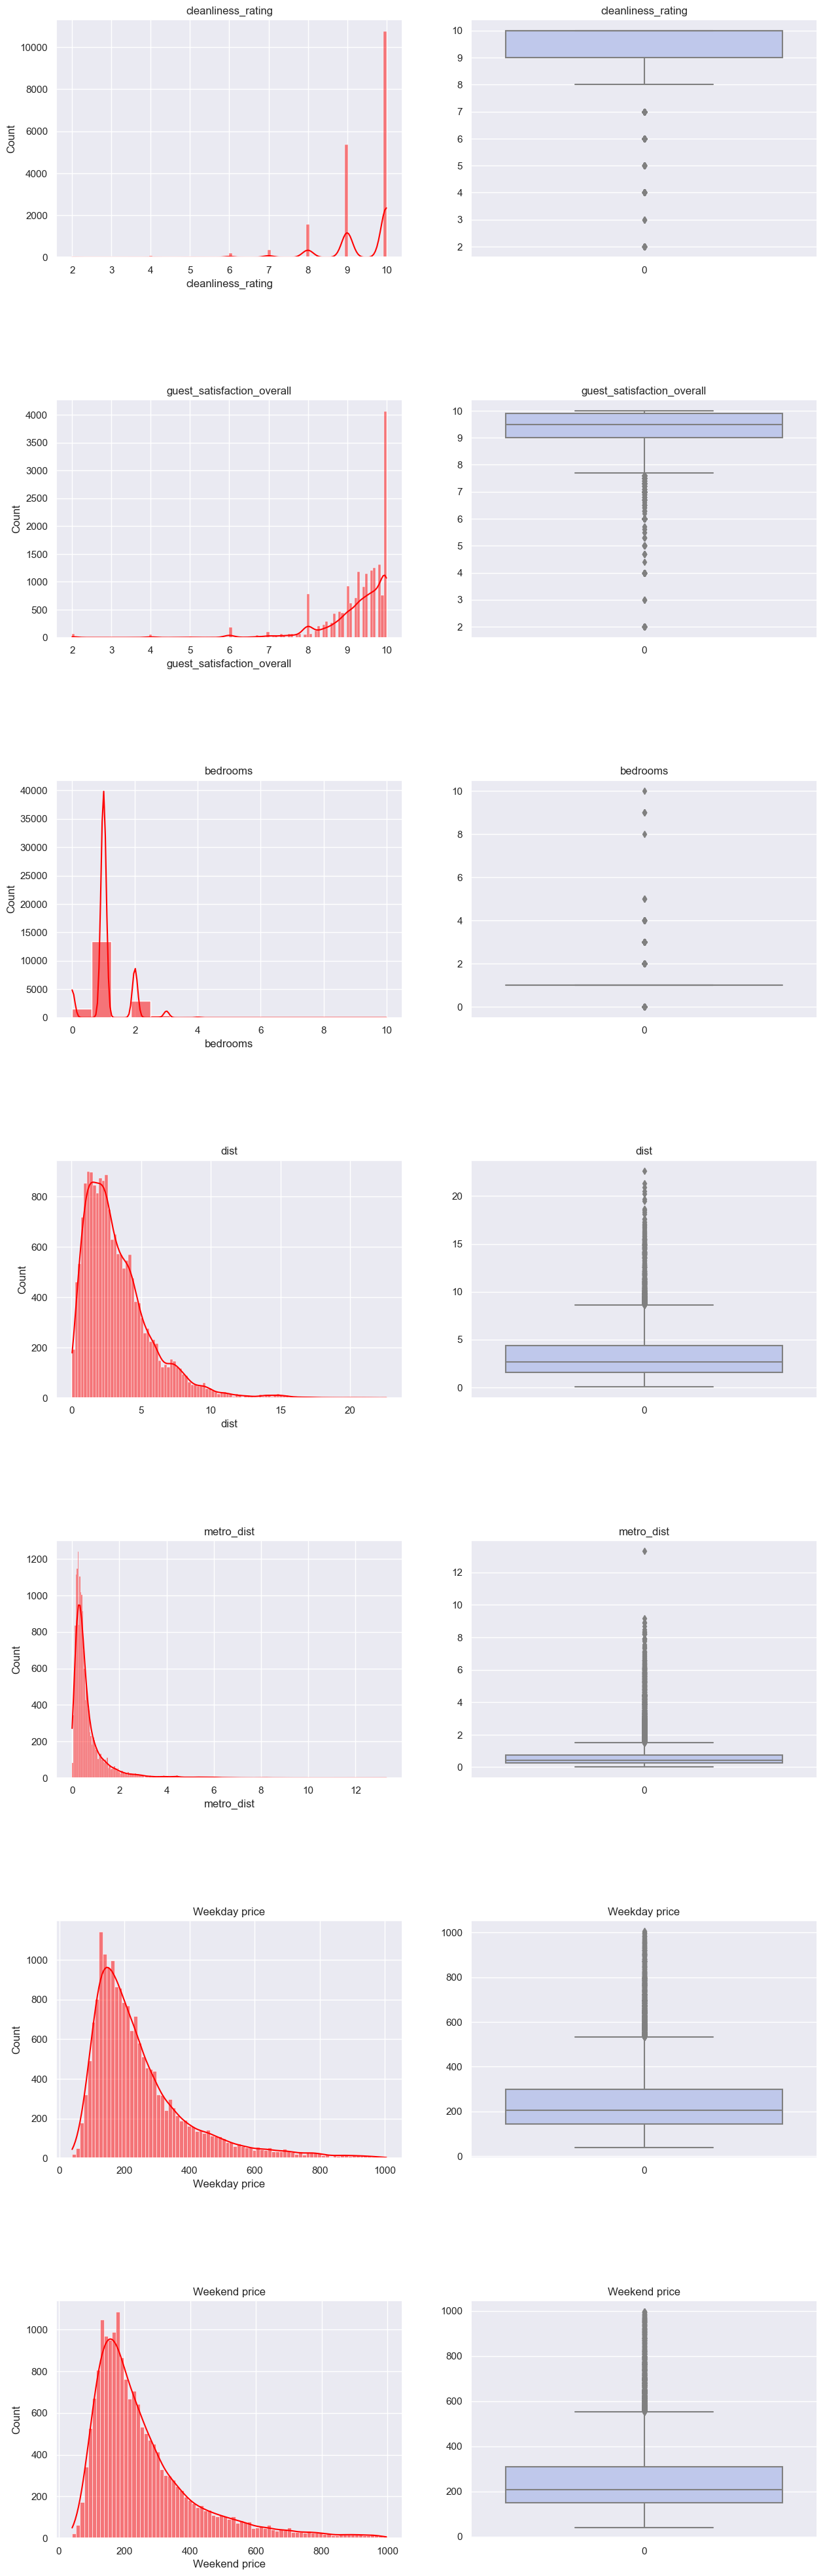

In [8]:
# Define  data and columns
data = common_locations_combined[['cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist', 'Weekday price', 'Weekend price']]

sns.set(style="darkgrid")

# Create a figure with subplots
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 50))

# Define a function for plotting histogram and box plot for each feature
def plot_continuous_data(feature, row):
    # Histogram
    sns.histplot(data=data[feature], ax=axes[row, 0], kde=True, color='red')
    axes[row, 0].set_title(str(feature))
    
    # Box plot
    sns.boxplot(data=data[feature], ax=axes[row, 1], color='#B7C3F3')
    axes[row, 1].set_title(str(feature))

# Loop through each column and plot histogram and box plot
for i, column in enumerate(data.columns):
    plot_continuous_data(column,  i)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.6)

# Show the plots
plt.show()


### Preprocess dataset to use columns weekend price and weekday price

In [9]:
# for some plots it was necessary to recreate the dataframe
# Create two separate dataframes for weekday and weekend prices
weekday_prices = common_locations_combined.drop( 'Weekend price', axis=1)
weekend_prices = common_locations_combined.drop( 'Weekday price', axis=1)

# Rename the columns to match in both dataframes
weekday_prices = weekday_prices.rename(columns={'Weekday price': 'Price'})
weekend_prices = weekend_prices.rename(columns={'Weekend price': 'Price'})

# Add a column for day type in each dataframe
weekday_prices['Day'] = 'Weekday'
weekend_prices['Day'] = 'Weekend'

# Combine the dataframes
prices = pd.concat([weekday_prices, weekend_prices])
prices = prices.drop("price_difference", axis=1)

In [10]:
prices

City        room_type  person_capacity  host_is_superhost  multi   
0      Amsterdam     Private room              2.0              False      0  \
1      Amsterdam     Private room              4.0              False      0   
2      Amsterdam     Private room              2.0               True      0   
5      Amsterdam     Private room              2.0              False      1   
6      Amsterdam  Entire home/apt              2.0              False      0   
...          ...              ...              ...                ...    ...   
18860     Vienna  Entire home/apt              4.0              False      0   
18861     Vienna  Entire home/apt              4.0              False      0   
18862     Vienna  Entire home/apt              2.0              False      0   
18863     Vienna  Entire home/apt              2.0              False      0   
18864     Vienna     Private room              4.0               True      1   

       biz  cleanliness_rating  guest_satisfaction_overall  bedrooms  dist   
0        1                 9.0                         8.7         1  5.75  \
1        1                 9.0                         9.0         2  0.38   
2        0                10.0                         9.8         1  0.54   
5        0                10.0                         8.8         1  3.14   
6        0                10.0                         9.6         1  1.01   
...    ...                 ...                         ...       ...   ...   
18860    0                 8.0                         8.0         0  0.30   
18861    1                10.0                        10.0         2  1.05   
18862    0                 8.0                         8.6         1  0.81   
18863    0                10.0                         9.3         1  0.99   
18864    0                10.0                         9.3         1  1.26   

       metro_dist       lng       lat   Price      Day  
0            3.65   4.97512  52.36103  264.10  Weekday  
1            0.44   4.89417  52.37663  433.53  Weekday  
2            0.32   4.90051  52.37508  485.55  Weekday  
5            0.92   4.87600  52.34700  276.52  Weekday  
6            0.92   4.87956  52.36953  909.47  Weekday  
...           ...       ...       ...     ...      ...  
18860        0.26  16.37766  48.20875  219.01  Weekend  
18861        0.33  16.37892  48.19973  214.57  Weekend  
18862        0.10  16.38070  48.20296  304.79  Weekend  
18863        0.20  16.38568  48.20460  637.17  Weekend  
18864        0.48  16.39066  48.20811  133.23  Weekend  

[36724 rows x 15 columns]

## Categorical Variables

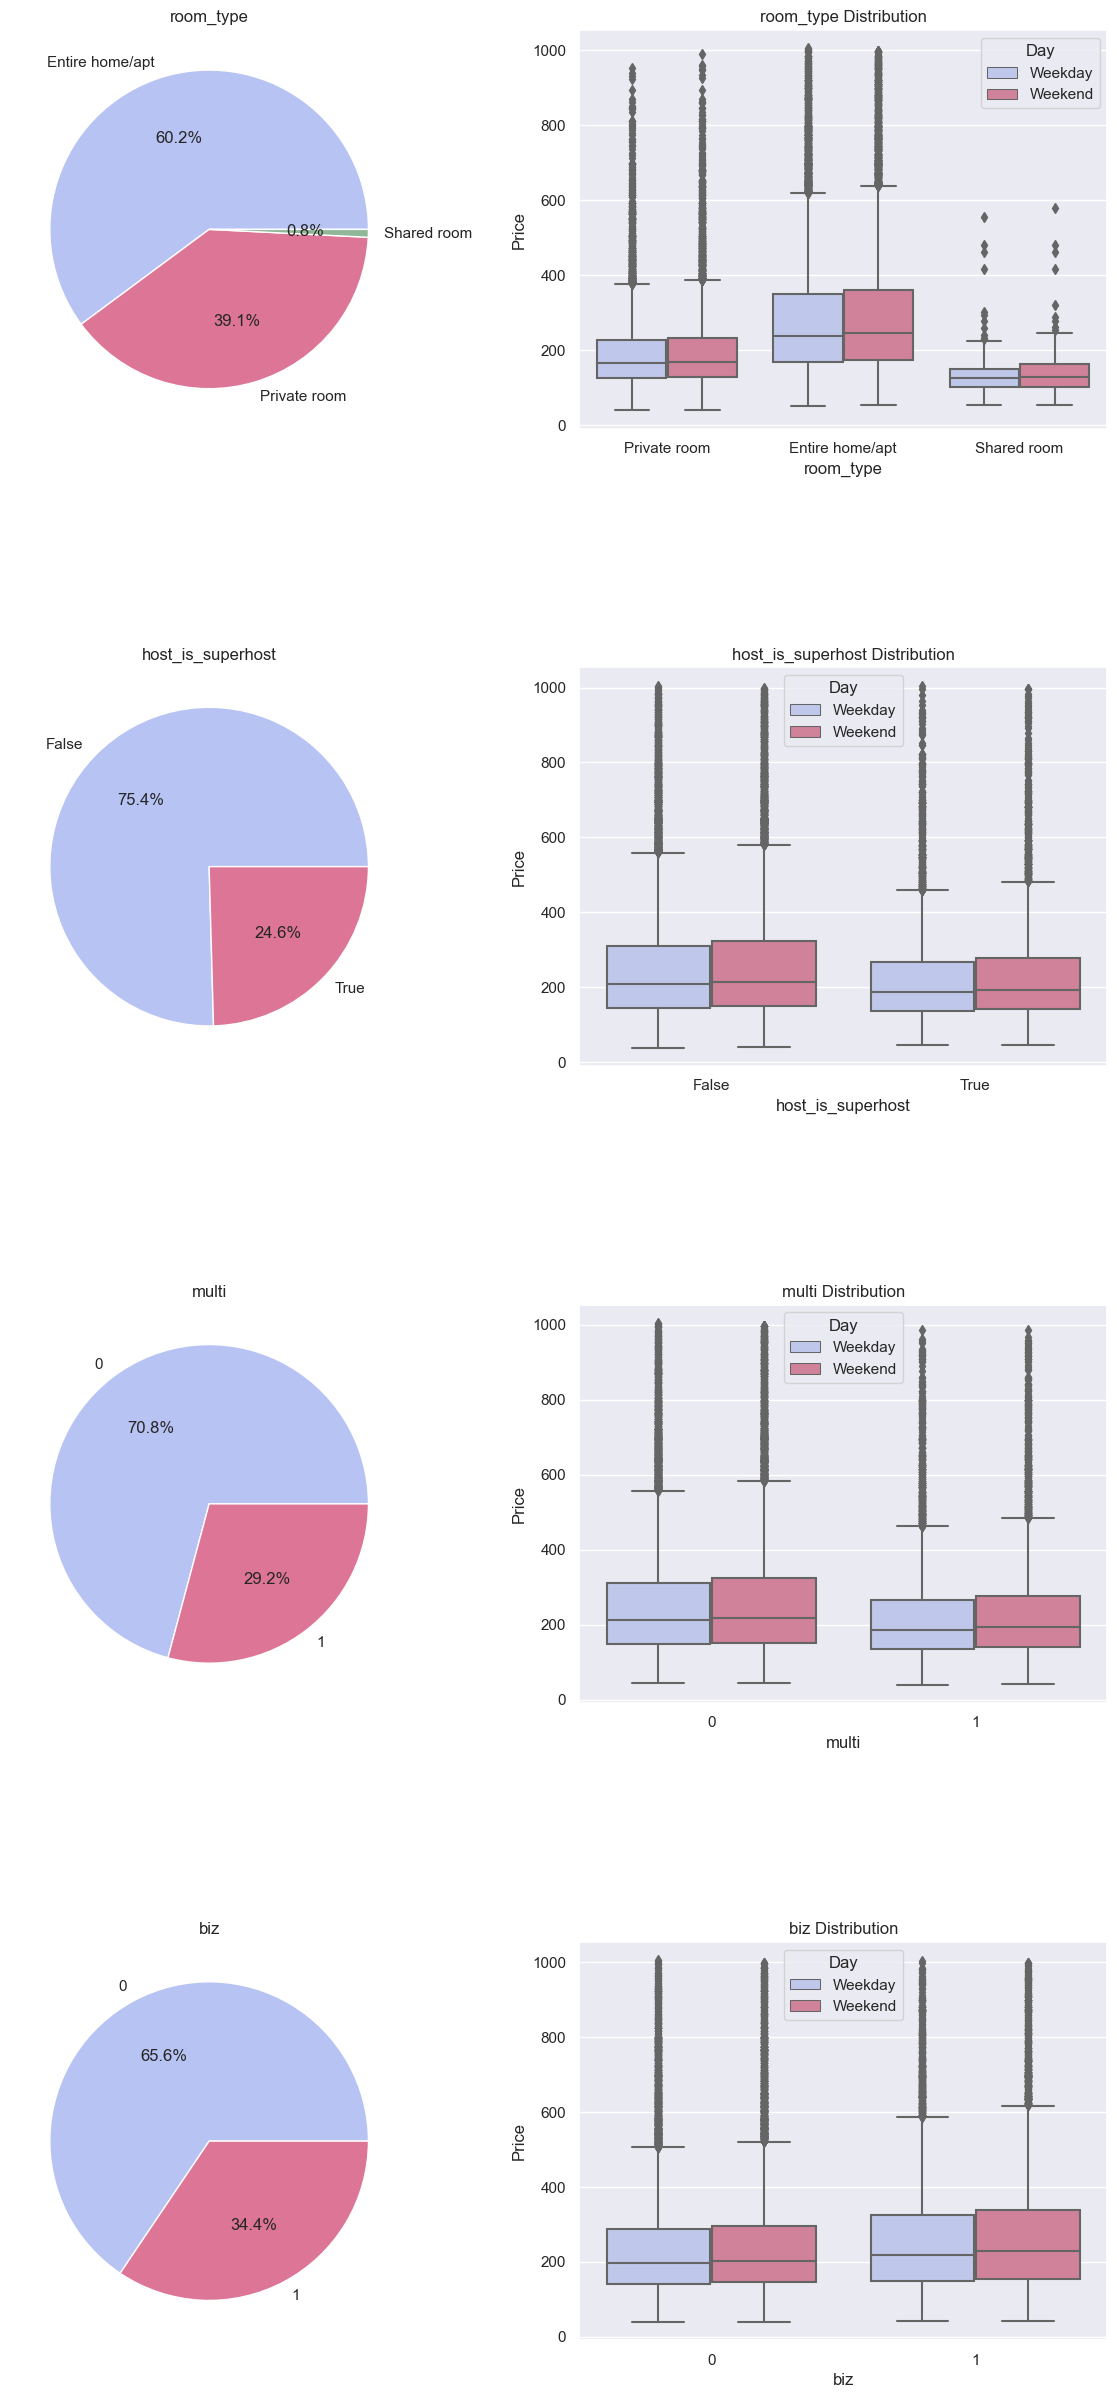

In [11]:
# Define  data and columns
data_categorical = common_locations_combined[['room_type', 'host_is_superhost', 'multi', 'biz', "Weekend price", "Weekday price"]]

colors = ['#B7C3F3', '#DD7596', '#8EB897']

# Colors
sns.set(style="darkgrid")

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 30))

# Define a function for plotting pie chart and box plots for each feature
def plot_categorical_data(feature, row):
    # Pie chart
    feature_counts = data_categorical[feature].value_counts()
    axes[row, 0].pie(feature_counts, labels=feature_counts.index, autopct='%1.1f%%', colors=colors)
    axes[row, 0].set_title(str(feature))

    # Box plots
    ax = axes[row, 1]
    sns.boxplot(data=prices, x=feature, y='Price', hue='Day', ax=ax, palette=colors)
    ax.set_title(str(feature) + " Distribution")

# Loop through each column and plot pie chart and box plots
for i, column in enumerate(data_categorical.columns[:4]):
    plot_categorical_data(column, i)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.6)

# Show the plots
plt.show()


## Relationships between columns - Scatterplots

In [12]:
def plot_city_correlation(data, price_column, column, plot_type='scatter'):
    stats = data.groupby('City')[column].agg(['min', 'max'])
    
    # Set the plot style and palette
    sns.set(style="darkgrid")
    sns.set_palette("muted")

    unique_cities = data['City'].unique()

    for city in unique_cities:
        # Filter the data for the current city
        city_data = data[data['City'] == city]

        # Get the minimum and maximum values of the chosen column for the current city
        min_value = stats.loc[city, 'min']
        max_value = stats.loc[city, 'max']

        # Create the plot based on the chosen plot_type
        if plot_type == 'scatter':
            # Create a scatter plot
            plt.scatter(city_data[column], city_data[price_column], label='Data points')
        elif plot_type == 'line':
            # Create a line plot
            plt.plot(city_data[column], city_data[price_column], label='Data points', marker='o')
        elif plot_type == 'bar':
            # Create a bar plot
            plt.bar(city_data[column], city_data[price_column], label='Data points')
        elif plot_type == 'box':
            # Create a box plot
            sns.boxplot(data=city_data, x=column, y=price_column)
        
        plt.xlabel(f'{column}')
        plt.ylabel(f'{price_column}')
        plt.title(f'{price_column} vs. {column} - {city}')
        
        # Set the x-axis limits based on the minimum and maximum values of the chosen column
        plt.xlim(min_value-0.4, max_value+0.4)

        # Perform linear regression
        x = city_data[column]
        y = city_data[price_column]
        slope, intercept = np.polyfit(x, y, 1)
        trendline = slope * x + intercept

        # Add the trendline to the plot
        plt.plot(x, trendline, color='red', label='Trendline')
        
        plt.legend()
        plt.show()


### Metro distance and Weekday price correlations by City

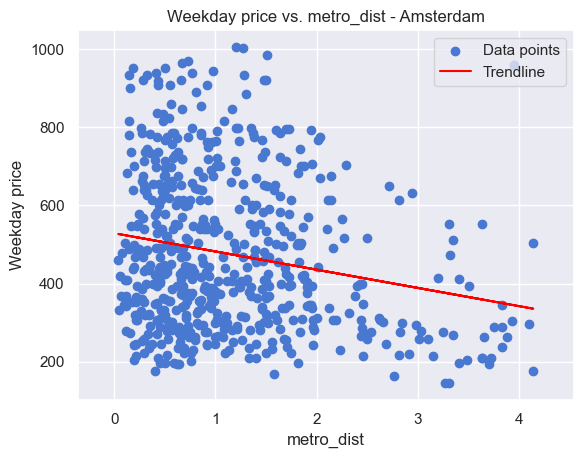

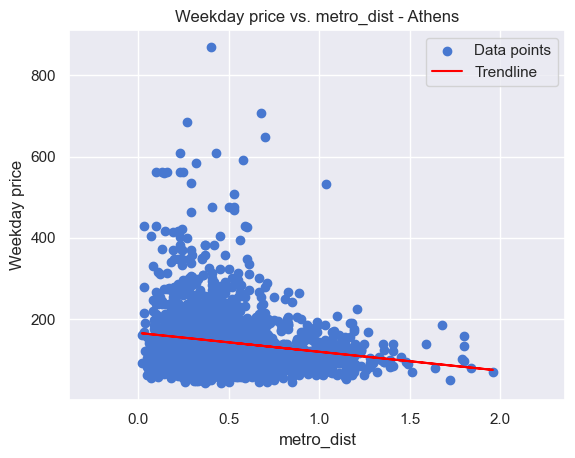

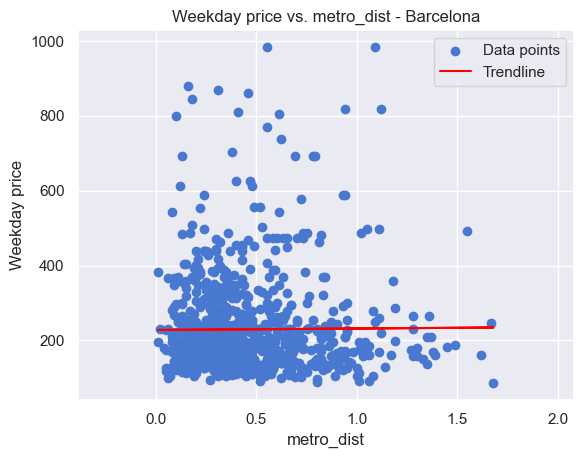

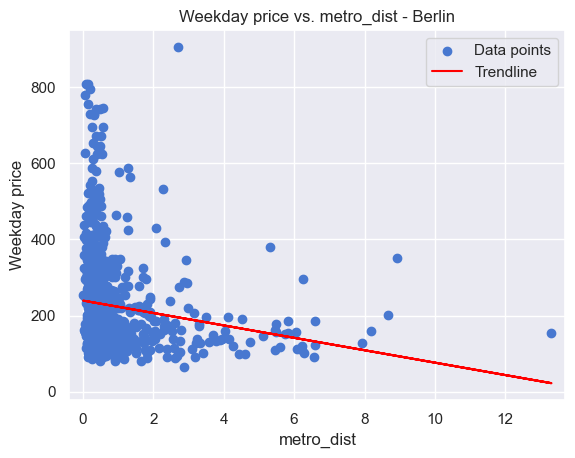

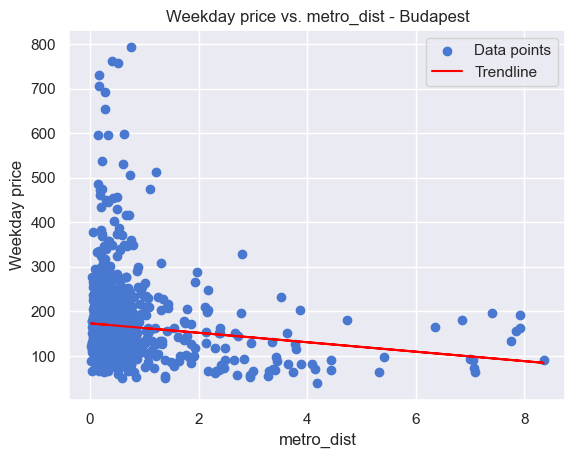

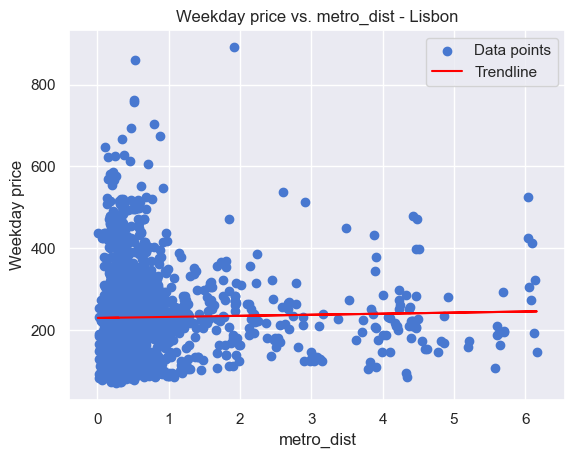

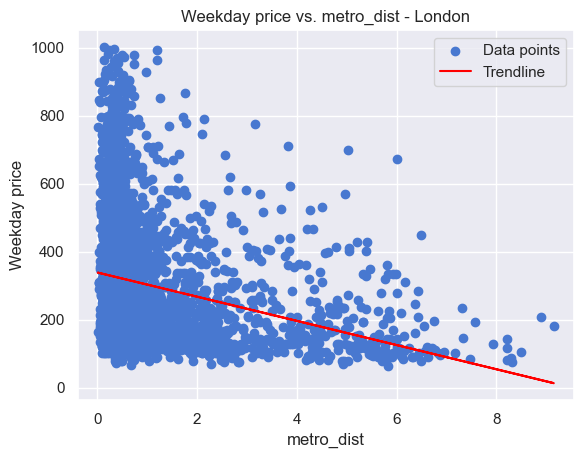

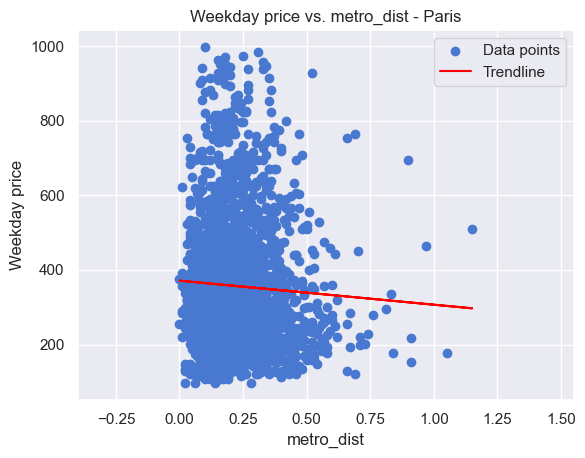

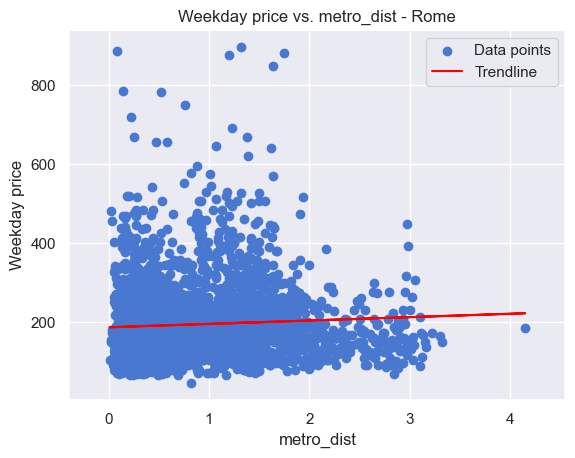

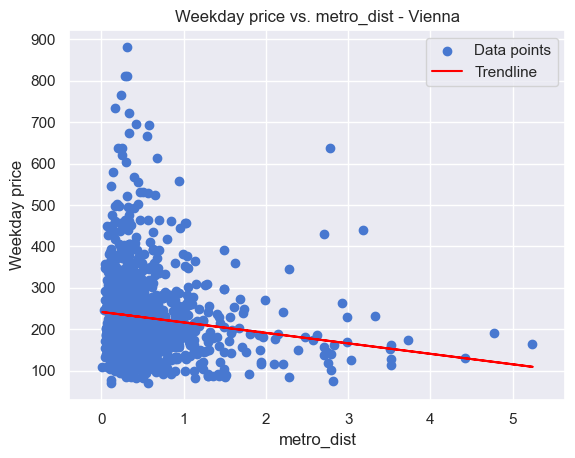

In [13]:
plot_city_correlation(common_locations_combined, 'Weekday price', 'metro_dist')

### Center distance and Weekday price correlations by City

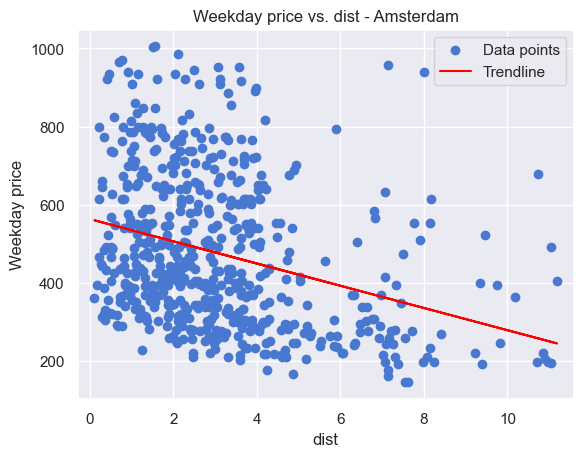

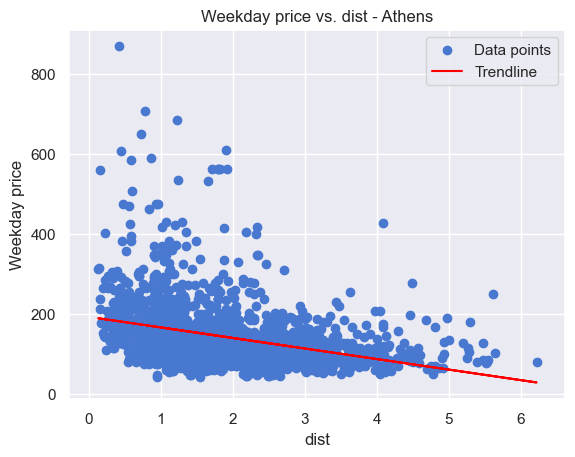

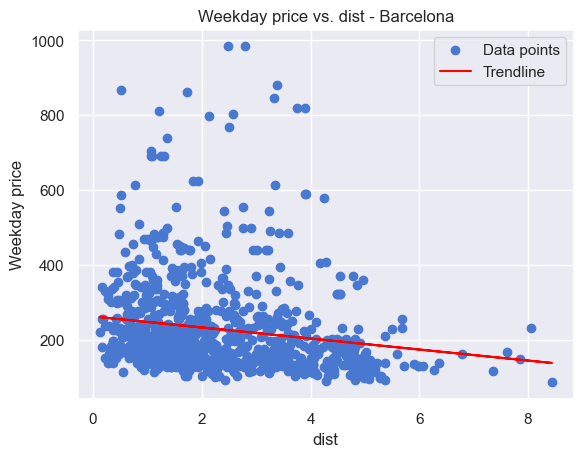

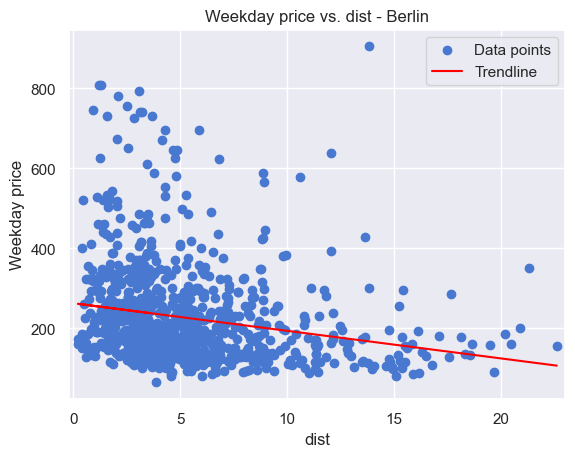

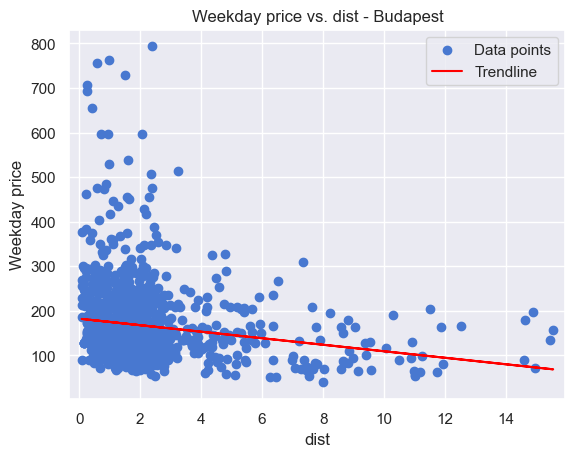

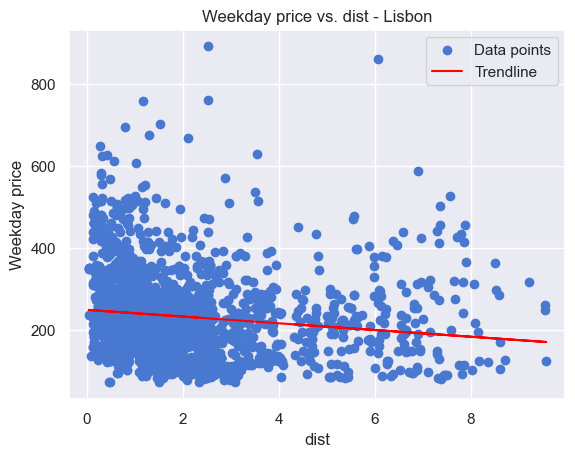

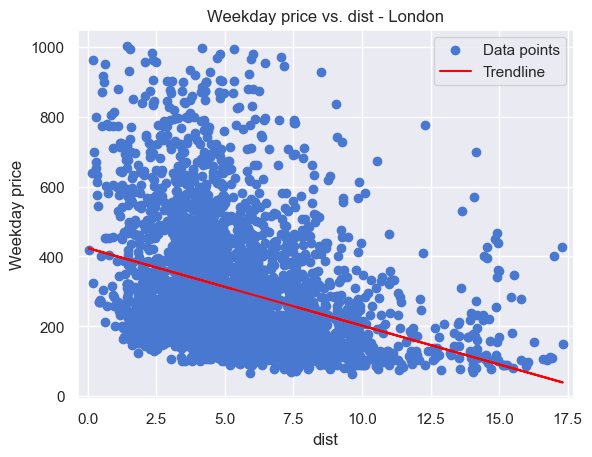

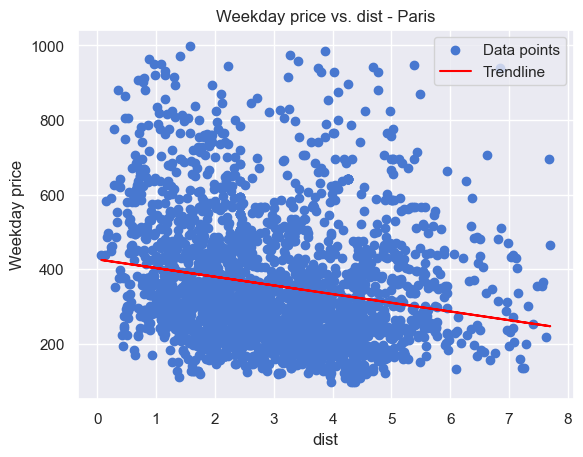

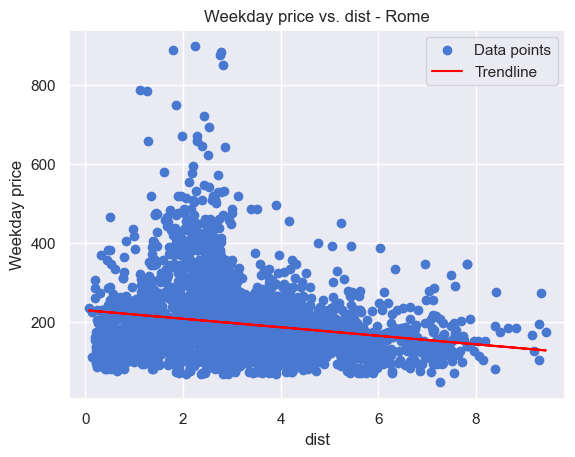

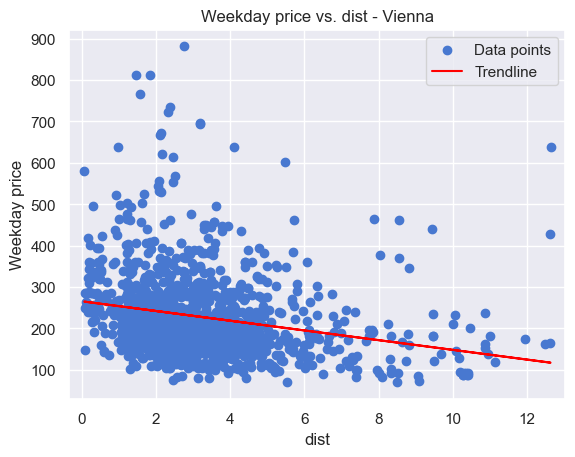

In [14]:
plot_city_correlation(common_locations_combined, 'Weekday price', 'dist')

### Person capacity and Weekday price correlation

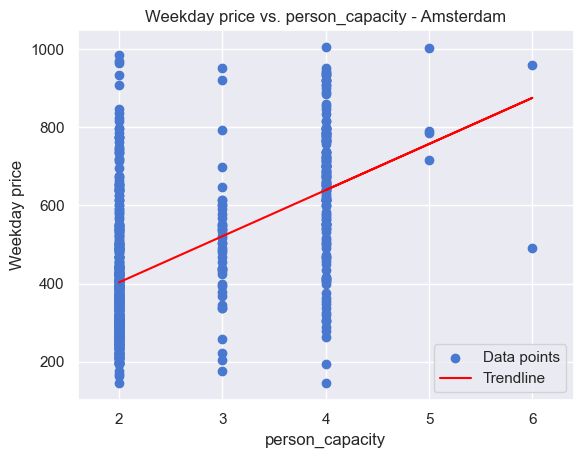

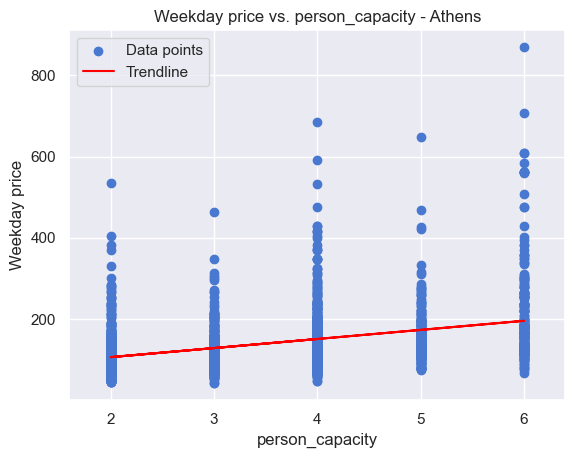

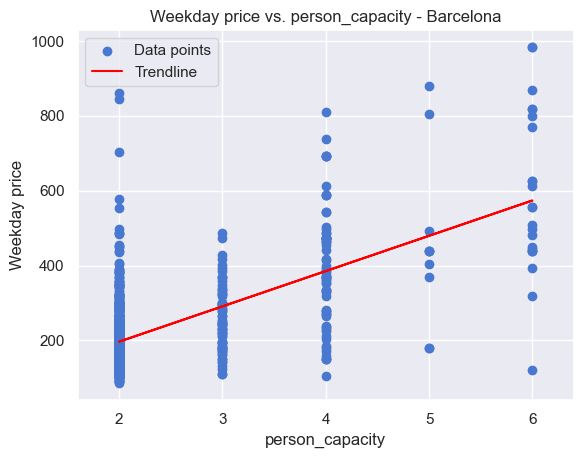

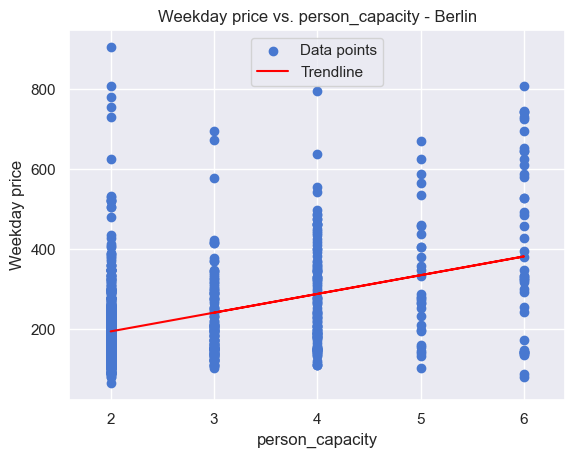

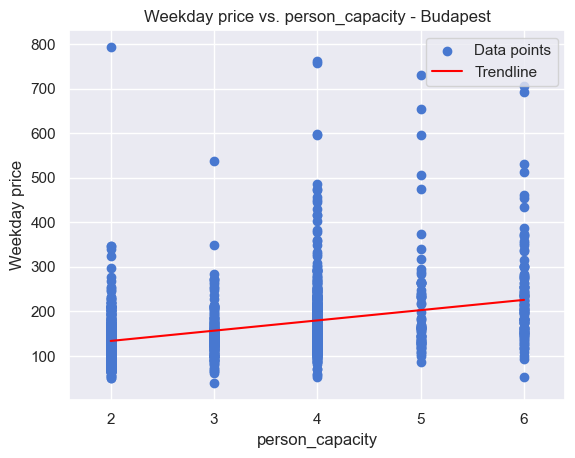

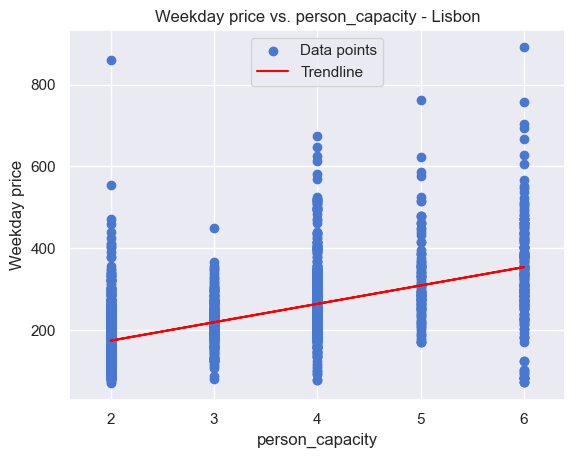

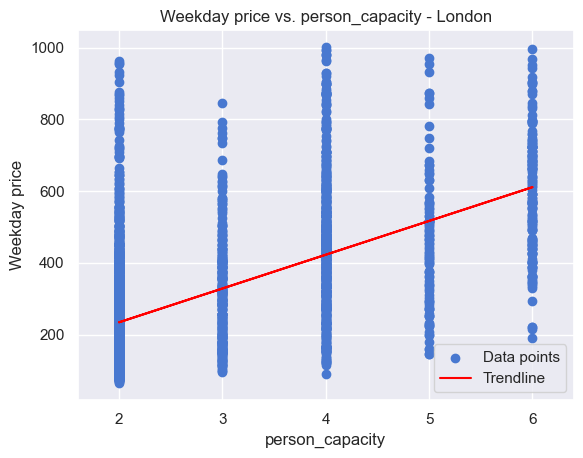

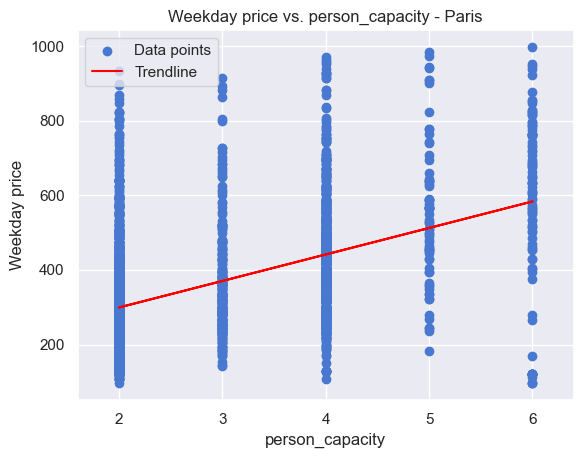

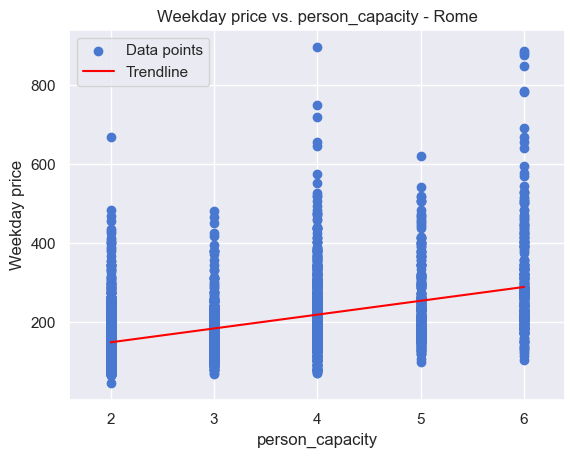

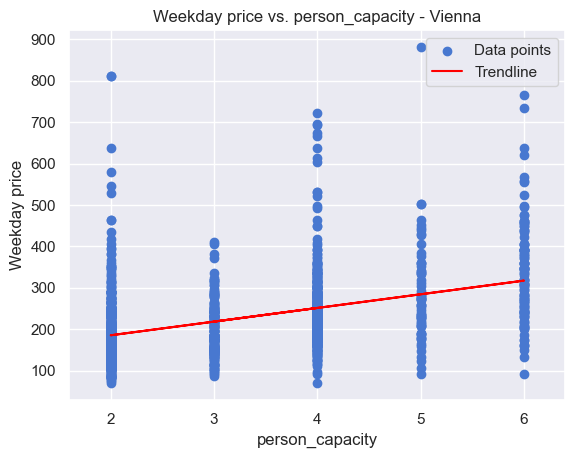

In [15]:
plot_city_correlation(common_locations_combined, 'Weekday price', 'person_capacity')

### Guest satisfaction and Weekday price correlation

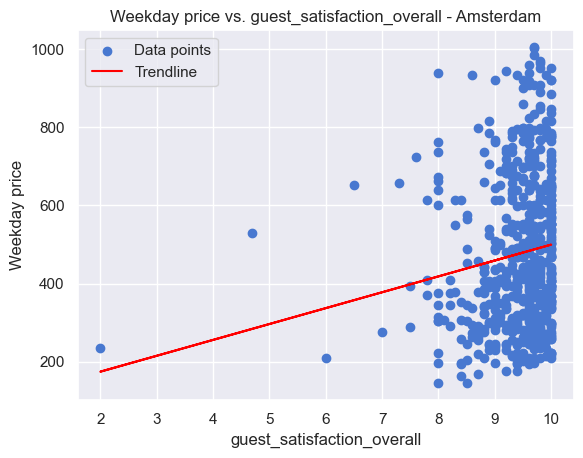

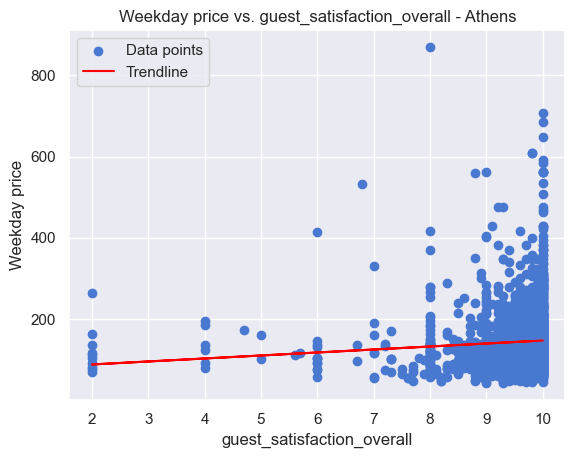

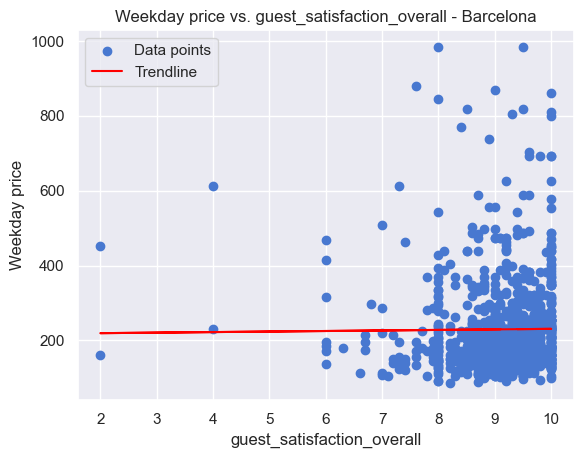

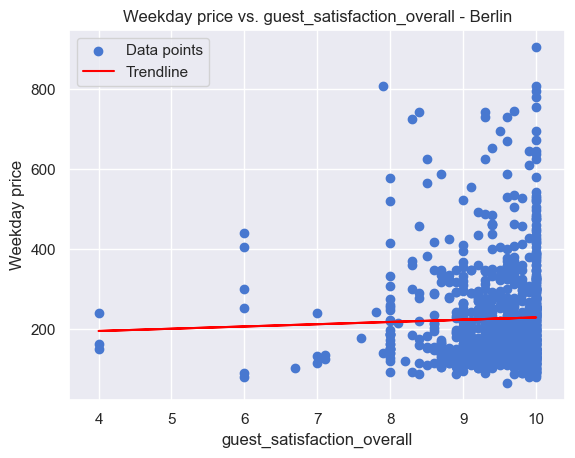

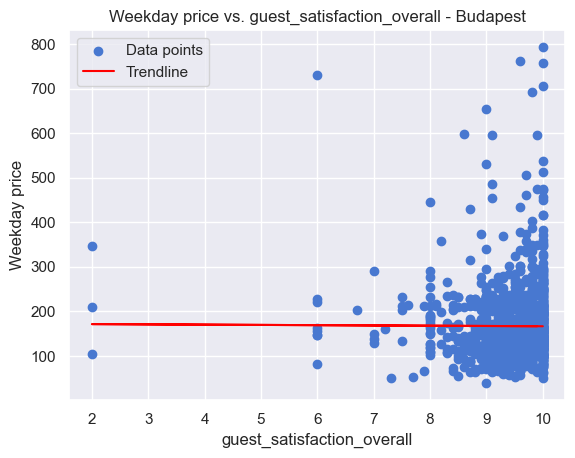

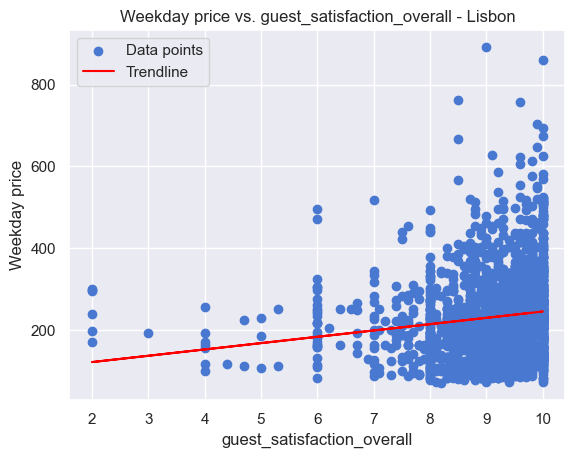

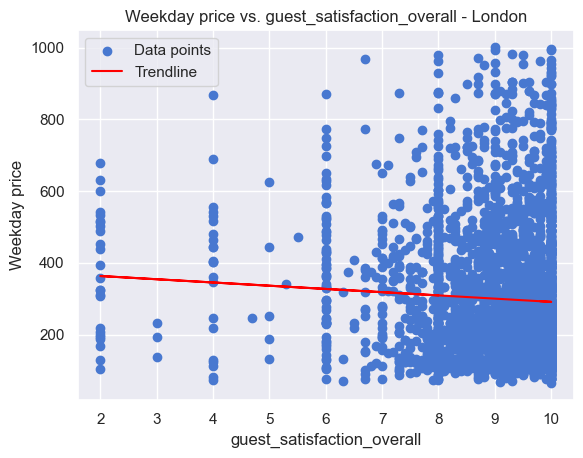

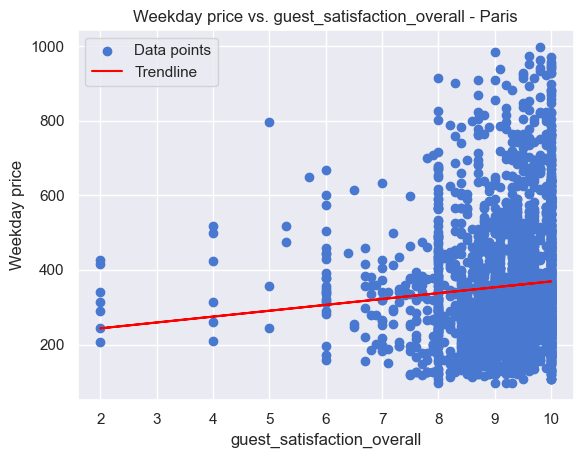

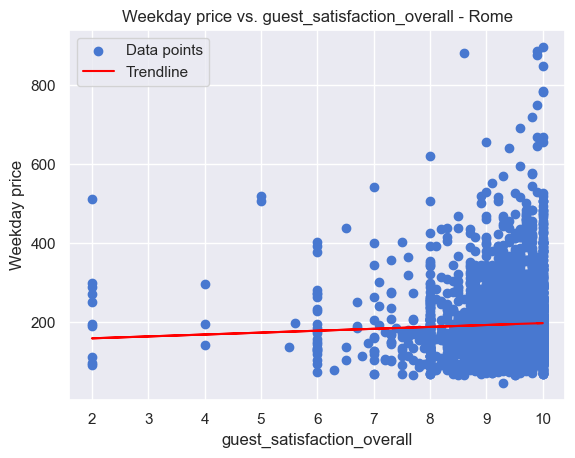

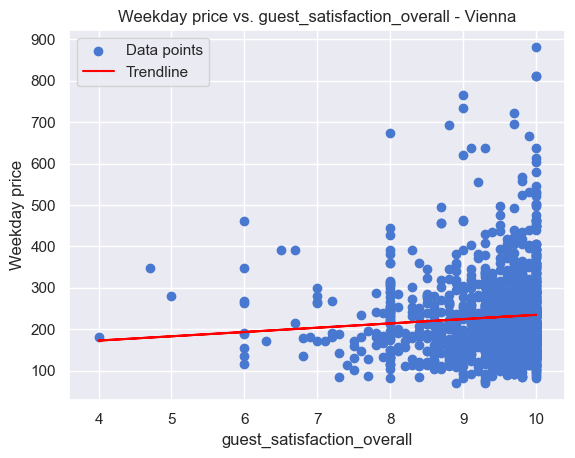

In [16]:
plot_city_correlation(common_locations_combined, 'Weekday price', 'guest_satisfaction_overall')

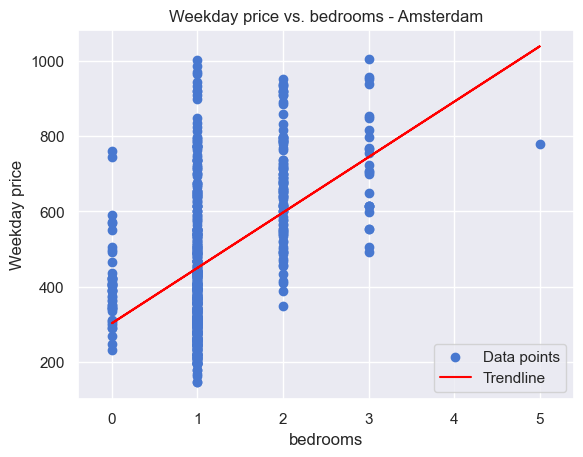

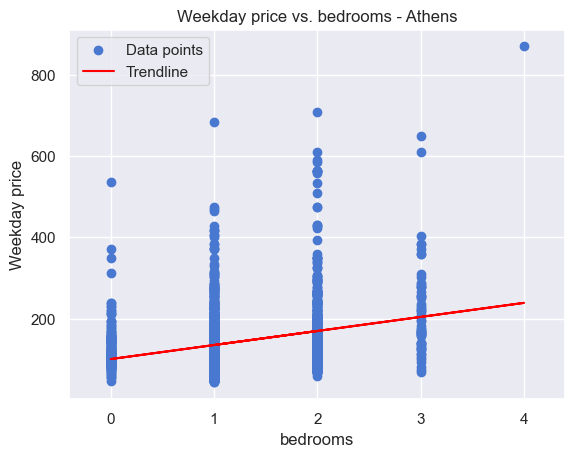

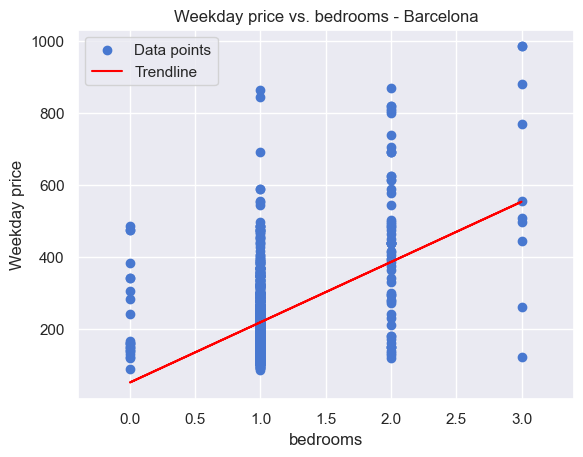

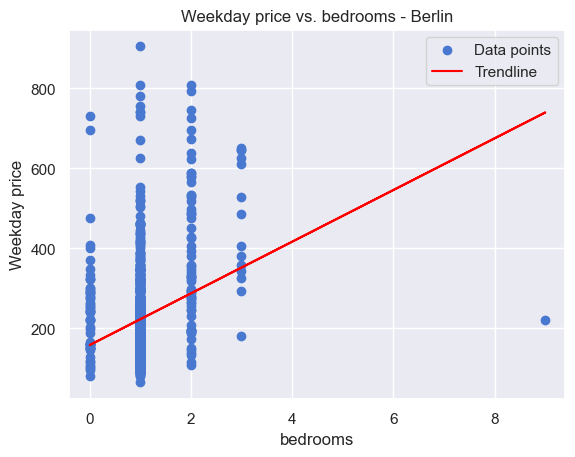

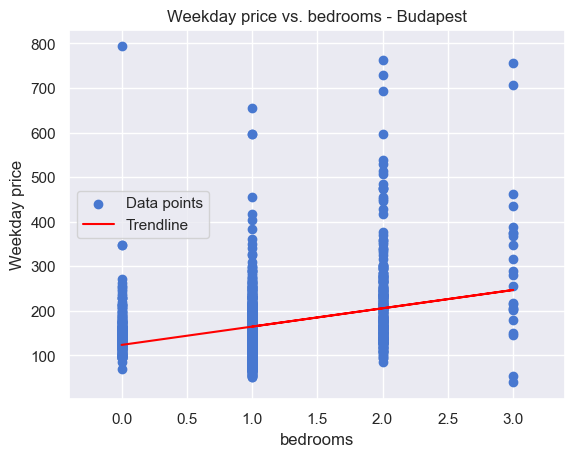

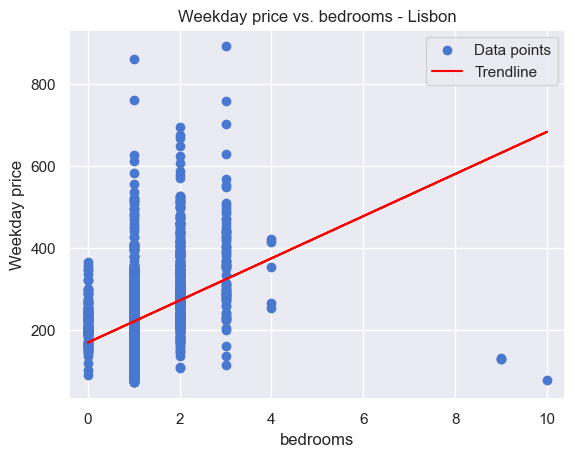

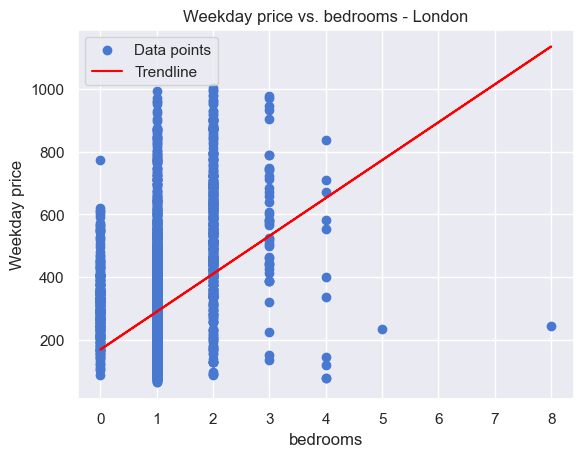

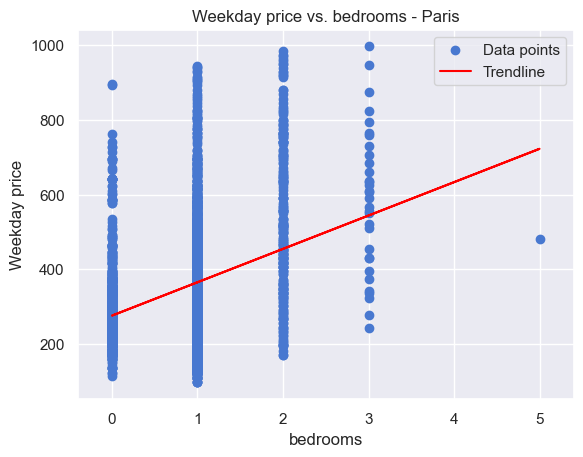

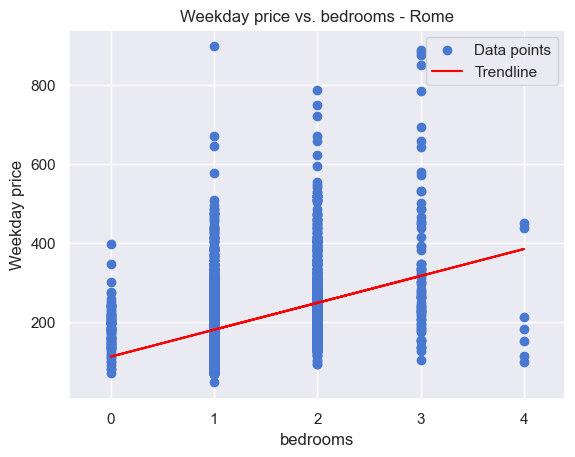

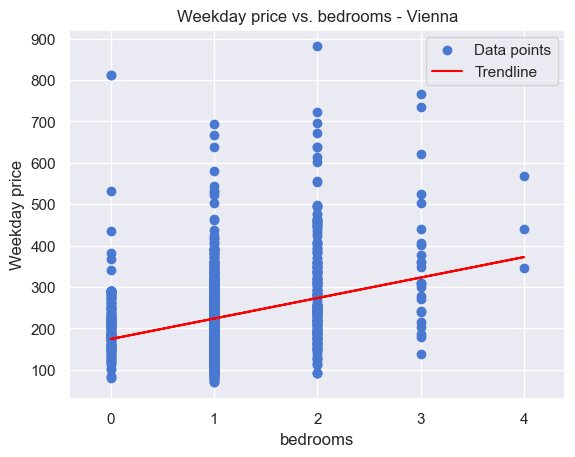

In [17]:
plot_city_correlation(common_locations_combined, 'Weekday price', 'bedrooms')

## City and Prices relationship

In [18]:
# Create box traces for weekday prices
weekday_box = go.Box(
    x=weekday_prices['City'],
      y=weekday_prices['Price'],
    name='Weekday Price'
)

# Create box traces for weekend prices
weekend_box = go.Box(
    x=weekend_prices['City'],
    y=weekend_prices['Price'],
    name='Weekend Price'
)

# Combine the box traces into a single list
data = [weekday_box, weekend_box]

# Set layout properties
layout = go.Layout(
    title='Distribution of Prices per City',
    xaxis=dict(title='City'),
    yaxis=dict(title='Prices'),
    boxmode='group'
)

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Show the plot
fig.show()



### Sunburst Chart of Room Types and Cities

In [19]:
# Create the Sunburst chart
fig = px.sunburst(common_locations_combined, path=['City', 'room_type'])

# Update layout properties
fig.update_layout(
    title='Sunburst Chart',
    margin=dict(t=40, l=0, r=0, b=0),
)

fig.show()

### Simple map with all data

In [ ]:
# Create a Folium map object
m = folium.Map(location=[common_locations_combined['lat'].mean(), common_locations_combined['lng'].mean()], zoom_start=3)
markerCluster = MarkerCluster().add_to(m)



# Add markers to the map
for i, row in common_locations_combined.iterrows():
    tooltip_text = (f"Room Type: {row['room_type']} <br> "
                        f"Distance to Center: {row['dist']} <br> "
                        f"Distance to Metro: {row['metro_dist']} <br> "
                        f"Weekday Price: {row['Weekday price']} <br> "
                        f"Weekend Price: {row['Weekend price']} <br> "
                       )
    
    lat = common_locations_combined.at[i, 'lat']
    lng = common_locations_combined.at[i, 'lng']
    
    folium.Marker(location=[lat, lng], tooltip = tooltip_text, icon=folium.Icon(color='blue', icon='house', prefix='fa')).add_to(markerCluster)

# Display the map
m


### Weekend and Weekday differences in Map

In [ ]:
common_locations_combined_plot1 = common_locations_combined.copy()

max_difference = common_locations_combined_plot1['price_difference'].max()
min_difference = common_locations_combined_plot1['price_difference'].min()


color_bins = [ min_difference,-10,  0, 50, 100, 150, 200, 250, 400, max_difference]
color_scale = ['purple', 'blue','red','green', 'pink', 'black', 'orange', "yellow", "gray", "white"]


common_locations_combined_plot1['color_category'] = pd.cut(common_locations_combined_plot1['price_difference'], bins=color_bins[:], labels=color_scale[:-1])
common_locations_combined_plot1['color_category'] = common_locations_combined_plot1['color_category'].astype('category')

# Create a scatter mapbox figure
fig = px.scatter_mapbox(
    common_locations_combined_plot1,
    lat='lat',
    lon='lng',
    color='color_category',
    color_discrete_sequence=color_scale,
    hover_data={'price_difference': True, 'Weekend price': True, 'Weekday price': True, 'room_type': True, 'guest_satisfaction_overall': True}, 
    labels={'color_category': 'Price Difference Interval'},
    zoom=3,
    category_orders={'color_category': color_scale}  
)

# Add custom legend labels for color categories
legend_labels = {
    'purple': f'[{min_difference}, -10]',
    'blue': '(-10, 0]',
    'red': '(0, 50]',
    'green': '(50, 100]',
    'pink': '(100, 150]',
    'black': '(150, 200]',
    'orange': '(200, 250]',
    'yellow': '(250, 400]',
    'gray': f'(400, {max_difference}]',
}

fig.update_traces(marker=dict(size=8))


# Update the names of traces to match the legend labels
fig.for_each_trace(lambda t: t.update(name=legend_labels[t.marker.color]))

# Set the mapbox style, margins, and hover template
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_traces(hovertemplate='<b>Price Difference:</b> %{customdata[0]}<br><b>Weekend price:</b> %{customdata[1]}<br><b>Weekday price:</b> %{customdata[2]}<br><b>Room Type:</b> %{customdata[3]}<br><b>Rating:</b> %{customdata[4]}<extra></extra>')  # Update hovertemplate

fig.show()


### Cheap, Average and Expensive Airbnb

In [ ]:
import plotly.express as px
from ipywidgets import interact

# Define the price categories
cheap_price = 100  # Define the threshold for cheap price
expensive_price = 300  # Define the threshold for expensive price

# Create a new column for price category
common_locations_combined_plot2 = common_locations_combined.copy()
common_locations_combined_plot2['price_category'] = pd.cut(common_locations_combined_plot2['Weekend price'], 
                                                    bins=[0, cheap_price, expensive_price, float('inf')],
                                                    labels=['Cheap (<100)', 'Average (100-300)', 'Expensive (>300)'])

# Define color mapping for the categories
color_mapping = {
    'Cheap (<100)': 'green',
    'Average (100-300)': 'yellow',
    'Expensive (>300)': 'red'
}

# Create a scatter mapbox figure
fig = px.scatter_mapbox(
    common_locations_combined_plot2,
    lat='lat',
    lon='lng',
    color='price_category',
    color_discrete_map=color_mapping,
    hover_data={
        'Weekend price': True,
        'price_category': False,  
        'room_type': True,
        'guest_satisfaction_overall': True,
        'lat': False,
        'lng': False,
    },
    labels={'price_category': 'Price Category'},
    zoom=3,
)

# Set the mapbox style and margins
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

# Update the marker size
fig.update_traces(marker=dict(size=8))

# Display the interactive map
fig.show()


### Interractive Map with Filters

In [ ]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from ipywidgets import interact_manual, Checkbox

# Define the update function
def update_map(**kwargs):
    # Create a new map
    m = folium.Map(location=[common_locations_combined['lat'].mean(), common_locations_combined['lng'].mean()], zoom_start=3)

    filtered_df = common_locations_combined.copy()

    # Apply filters
    for key, value in kwargs.items():
        if key == 'room_type_check' and value:
            filtered_df = filtered_df[filtered_df['room_type'] == kwargs['room_type']]
        elif key == 'metro_dist_check' and value:
            filtered_df = filtered_df[filtered_df['metro_dist'] <= kwargs['metro_dist']]
        elif key == 'bedrooms_check' and value:
            filtered_df = filtered_df[filtered_df['bedrooms'] == kwargs['bedrooms']]
        elif key == 'center_distance_check' and value:
            filtered_df = filtered_df[filtered_df['dist'] <= kwargs['center_distance']]
        elif key == 'host_is_superhost_check' and value:
            filtered_df = filtered_df[filtered_df['host_is_superhost']]
        elif key == 'weekend_price_check' and value:
            filtered_df = filtered_df[filtered_df['Weekend price'] <= kwargs['weekend_price']]
        elif key == 'weekday_price_check' and value:
            filtered_df = filtered_df[filtered_df['Weekday price'] <= kwargs['weekday_price']]
        elif key == 'guest_satisfaction_check' and value:
            filtered_df = filtered_df[filtered_df['guest_satisfaction_overall'] >= kwargs['guest_satisfaction']]
        elif key == 'cleanliness_rating_check' and value:
            filtered_df = filtered_df[filtered_df['cleanliness_rating'] >= kwargs['cleanliness_rating']]

    # Add marker clusters to the map
    marker_cluster = MarkerCluster().add_to(m)

    # Add markers to the marker cluster
    for _, row in filtered_df.iterrows():
        tooltip_text = (f"Room Type: {row['room_type']}, <br> "
                        f"Distance to Center: {row['dist']}, <br> "
                        f"Distance to Metro: {row['metro_dist']}, <br> "
                        f"Weekday Price: {row['Weekday price']}, <br> "
                        f"Weekend Price: {row['Weekend price']}, <br> "
                        f"Cleanliness: {row['cleanliness_rating']}, <br> "
                        f"Guest Satisfaction: {row['guest_satisfaction_overall']}")

        folium.Marker(
            location=[row['lat'], row['lng']],
            tooltip=tooltip_text,
            icon=folium.Icon(color='green', icon='house', prefix='fa'),
        ).add_to(marker_cluster)

    # Add circles for city centers
    city_centers = {
        'Amsterdam': (52.379189, 4.899431),
        'Athens': (37.983810, 23.727539),
        'Barcelona': (41.385064, 2.173404),
        'Berlin': (52.520008, 13.404954),
        'Budapest': (47.497913, 19.040236),
        'Lisbon': (38.722252, -9.139337),
        'London': (51.5074, -0.1278),
        'Paris': (48.8566, 2.3522),
        'Rome': (41.9028, 12.4964),
        'Vienna': (48.2082, 16.3738)
    }

    for city, center in city_centers.items():
        folium.Circle(
            location=center,
            radius=2000,  # 2 km radius
            color='blue',
            fill=True,
            fill_opacity=0.2,
            popup=city,
        ).add_to(m)

    # Display the map
    display(m)

# Create the interactive filter function
@interact_manual(
    room_type_check=Checkbox(value=False),
    room_type=['Entire home/apt', 'Private room', 'Shared room'],
    metro_dist_check=Checkbox(value=False),
    metro_dist=(0, 10),
    bedrooms_check=Checkbox(value=False),
    bedrooms=(0, 10),
    center_distance_check=Checkbox(value=False),
    center_distance=(0, 23),
    host_is_superhost_check=Checkbox(value=False),
    weekend_price_check=Checkbox(value=False),
    weekend_price=(0, 1000),
    weekday_price_check=Checkbox(value=False),
    weekday_price=(0, 1000),
    guest_satisfaction_check=Checkbox(value=False),
    guest_satisfaction=(0, 10),
    cleanliness_rating_check=Checkbox(value=False),
    cleanliness_rating=(0, 10)
)
def interact_update_map(**kwargs):
    update_map(**kwargs)
